In [19]:
# evaluate an ARIMA model using a walk-forward validation
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (28, 14)



In [1]:
# apply the augmented Dicky-Fuller stationarity test

# recap: The null hypothesis is that the time series is NOT-stationary
# i.e. a small p value, less than 0.05, means that you have a stationary series

def print_adf(data):
    """ 
    Prints the results of the augmented Dickey Fuller Test
    """
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(
        data)

    print(f""" 
              adf_stats: {adf_stats}
              p: {p} 
              used lag: {used_lag} 
              number of observations: {n_obs}
            
              CI 99%: {levels['1%']}
              CI 95%: {levels['5%']}
              CI 90%: {levels['10%']}
              information criterion (AIC): {information_criterion}
            """)


In [ ]:
# grid search sarima hyperparameters for monthly mean temp dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step sarima forecast

# model configs
cfg_list = sarima_configs(seasonal=[0, 12])

def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend,
	                enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse


def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets


def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data


def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure


def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs


def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try


def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n', 'c', 't', 'ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p, d, q), (P, D, Q, m), t]
									models.append(cfg)
	return models


if __name__ == '__main__':
	# load dataset
	series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
	data = series.values
	# trim dataset to 5 years
	data = data[-(5*12):]
	# data split
	n_test = 12
	# model configs
	cfg_list = sarima_configs(seasonal=[0, 12])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)


In [11]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
cg = CoinGeckoAPI()

#a = cg.get_price(ids=['bitcoin', 'ethereum'], vs_currencies='eur')

#a = cg.get_coin_market_chart_range_by_id('bitcoin','eur',1642702654, 1643322882)

a = cg.get_coin_market_chart_by_id('bitcoin', 'eur', 3196)

#print(((a['prices'][-1][1])/(a['prices'][0][1]))-1)

df = pd.DataFrame(a)

df.to_csv('bro.csv')


In [12]:
# df = pd.read_csv('bro.csv',index_col=0)
df.head()

,prices,market_caps,total_volumes
0,"[1367280000000, 106.3128]","[1367280000000, 1179936531.5728781]","[1367280000000, 0.0]"
1,"[1367366400000, 88.6291]","[1367366400000, 983973562.5649999]","[1367366400000, 0.0]"
2,"[1367452800000, 80.5923]","[1367452800000, 895037935.3354017]","[1367452800000, 0.0]"
3,"[1367539200000, 75.1575]","[1367539200000, 834954730.4999999]","[1367539200000, 0.0]"
4,"[1367625600000, 86.2273]","[1367625600000, 958267697.6012692]","[1367625600000, 0.0]"


In [13]:
df['date'] = df.prices.apply(lambda x: x[0])

df['price'] = df.prices.apply(lambda x: x[1])


In [14]:
df.head()

,prices,market_caps,total_volumes,date,price
0,"[1367280000000, 106.3128]","[1367280000000, 1179936531.5728781]","[1367280000000, 0.0]",1367280000000,106.3128
1,"[1367366400000, 88.6291]","[1367366400000, 983973562.5649999]","[1367366400000, 0.0]",1367366400000,88.6291
2,"[1367452800000, 80.5923]","[1367452800000, 895037935.3354017]","[1367452800000, 0.0]",1367452800000,80.5923
3,"[1367539200000, 75.1575]","[1367539200000, 834954730.4999999]","[1367539200000, 0.0]",1367539200000,75.1575
4,"[1367625600000, 86.2273]","[1367625600000, 958267697.6012692]","[1367625600000, 0.0]",1367625600000,86.2273


In [15]:
df['date'] = pd.to_datetime(df['date'].astype(int), unit="ms")

### Attention to the type ###
df.head()

,prices,market_caps,total_volumes,date,price
0,"[1367280000000, 106.3128]","[1367280000000, 1179936531.5728781]","[1367280000000, 0.0]",2013-04-30,106.3128
1,"[1367366400000, 88.6291]","[1367366400000, 983973562.5649999]","[1367366400000, 0.0]",2013-05-01,88.6291
2,"[1367452800000, 80.5923]","[1367452800000, 895037935.3354017]","[1367452800000, 0.0]",2013-05-02,80.5923
3,"[1367539200000, 75.1575]","[1367539200000, 834954730.4999999]","[1367539200000, 0.0]",2013-05-03,75.1575
4,"[1367625600000, 86.2273]","[1367625600000, 958267697.6012692]","[1367625600000, 0.0]",2013-05-04,86.2273


In [16]:
df.drop(columns=['prices', 'total_volumes','market_caps'], inplace=True)

In [17]:
df.set_index('date', inplace=True)
df.tail()


,price
date,
2022-01-25 00:00:00,32475.015385
2022-01-26 00:00:00,32723.735164
2022-01-27 00:00:00,32807.243920
2022-01-28 00:00:00,33451.639390
2022-01-28 14:10:26,33157.810831


<AxesSubplot:xlabel='date'>

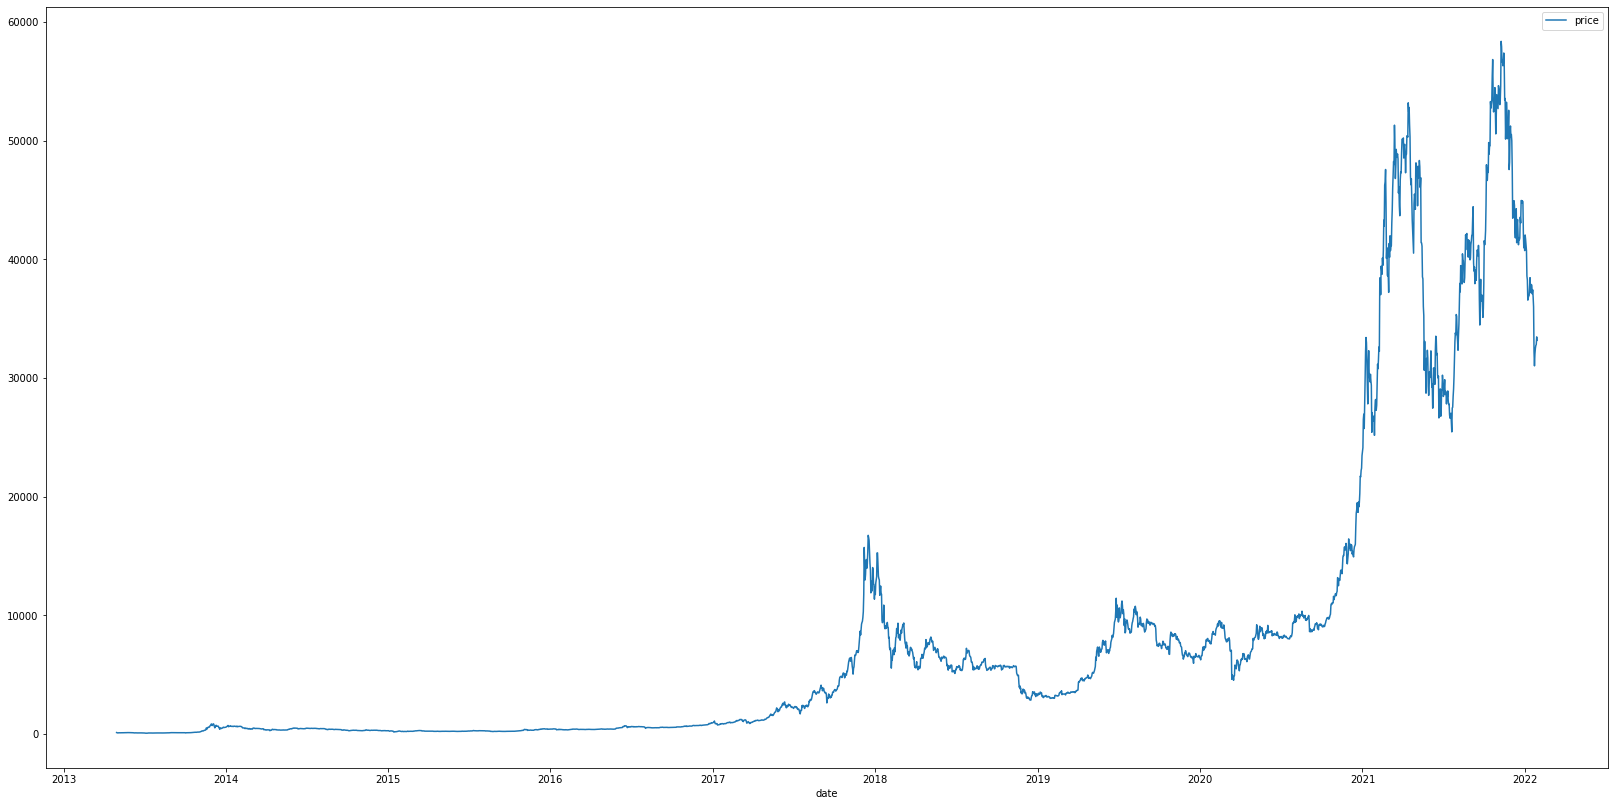

In [20]:
sns.lineplot(data=df)

In [21]:
print_adf(df)

 
              adf_stats: -1.1497256036346624
              p: 0.6948403362659923 
              used lag: 29 
              number of observations: 3165
            
              CI 99%: -3.432417807760863
              CI 95%: -2.862453630885886
              CI 90%: -2.5672563467676928
              information criterion (AIC): 49348.861667069745
            


In [22]:
df['diff'] = df['price'].diff()
df.head()

,price,diff
date,,
2013-04-30,106.3128,NaN
2013-05-01,88.6291,-17.6837
2013-05-02,80.5923,-8.0368
2013-05-03,75.1575,-5.4348
2013-05-04,86.2273,11.0698


In [23]:
df.dropna(inplace=True)
df.head()

,price,diff
date,,
2013-05-01,88.6291,-17.6837
2013-05-02,80.5923,-8.0368
2013-05-03,75.1575,-5.4348
2013-05-04,86.2273,11.0698
2013-05-05,88.4403,2.2130


In [24]:
df_train = df.loc['2013':'2021']
df_test = df.loc['2022']

In [25]:
df_train.tail()

,price,diff
date,,
2021-12-27,44908.059189,162.219371
2021-12-28,44818.168112,-89.891078
2021-12-29,42181.442574,-2636.725538
2021-12-30,40960.337931,-1221.104643
2021-12-31,41672.354655,712.016724


In [26]:
print_adf(df['diff'])


 
              adf_stats: -9.039922312863057
              p: 5.166666357841198e-15 
              used lag: 28 
              number of observations: 3165
            
              CI 99%: -3.432417807760863
              CI 95%: -2.862453630885886
              CI 90%: -2.5672563467676928
              information criterion (AIC): 49333.62285938372
            


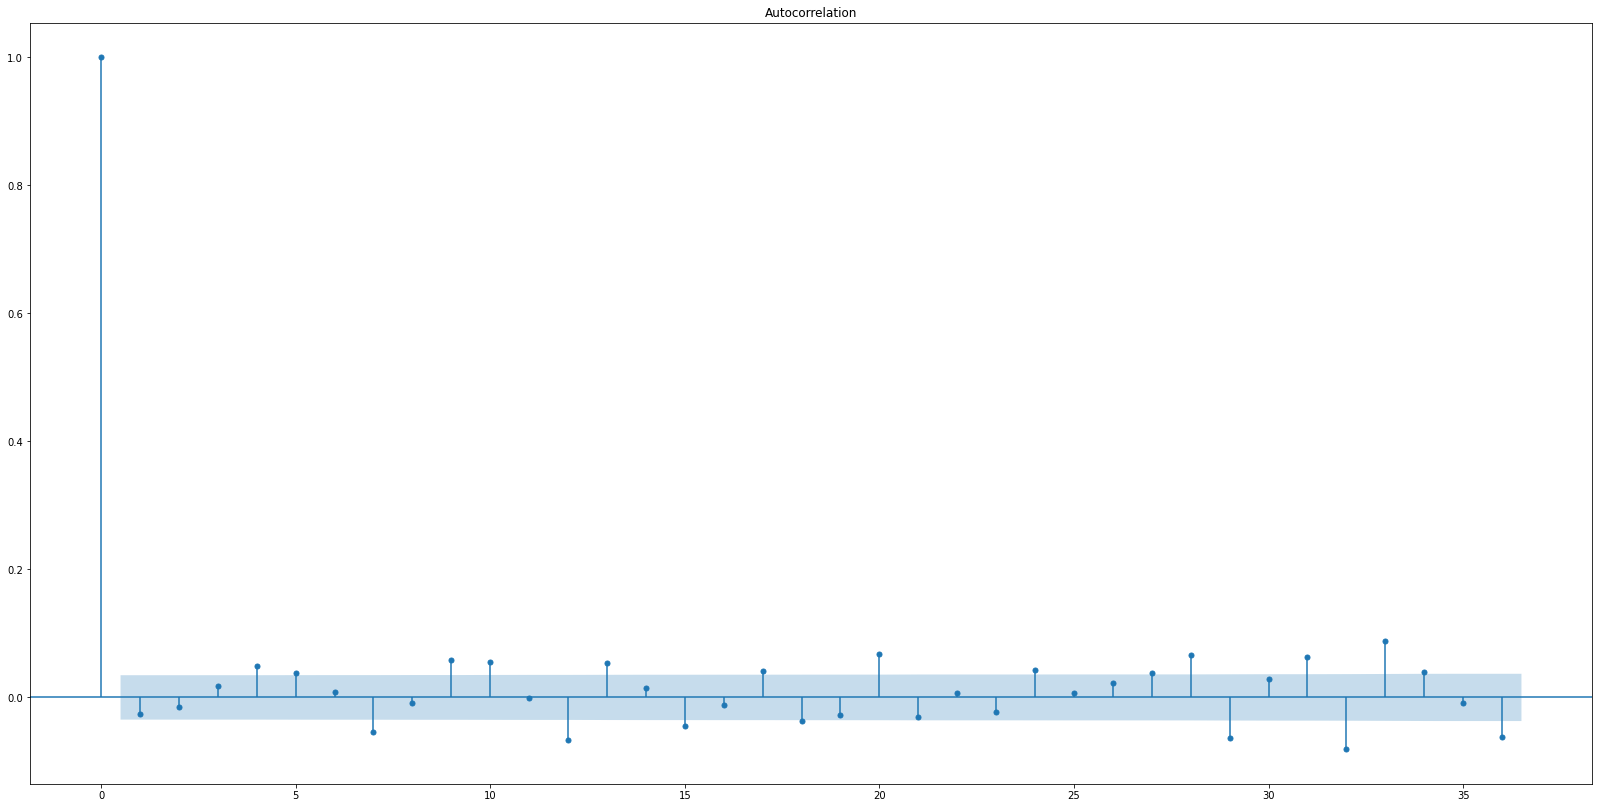

In [27]:
plot_acf(df['diff'])
plt.show()

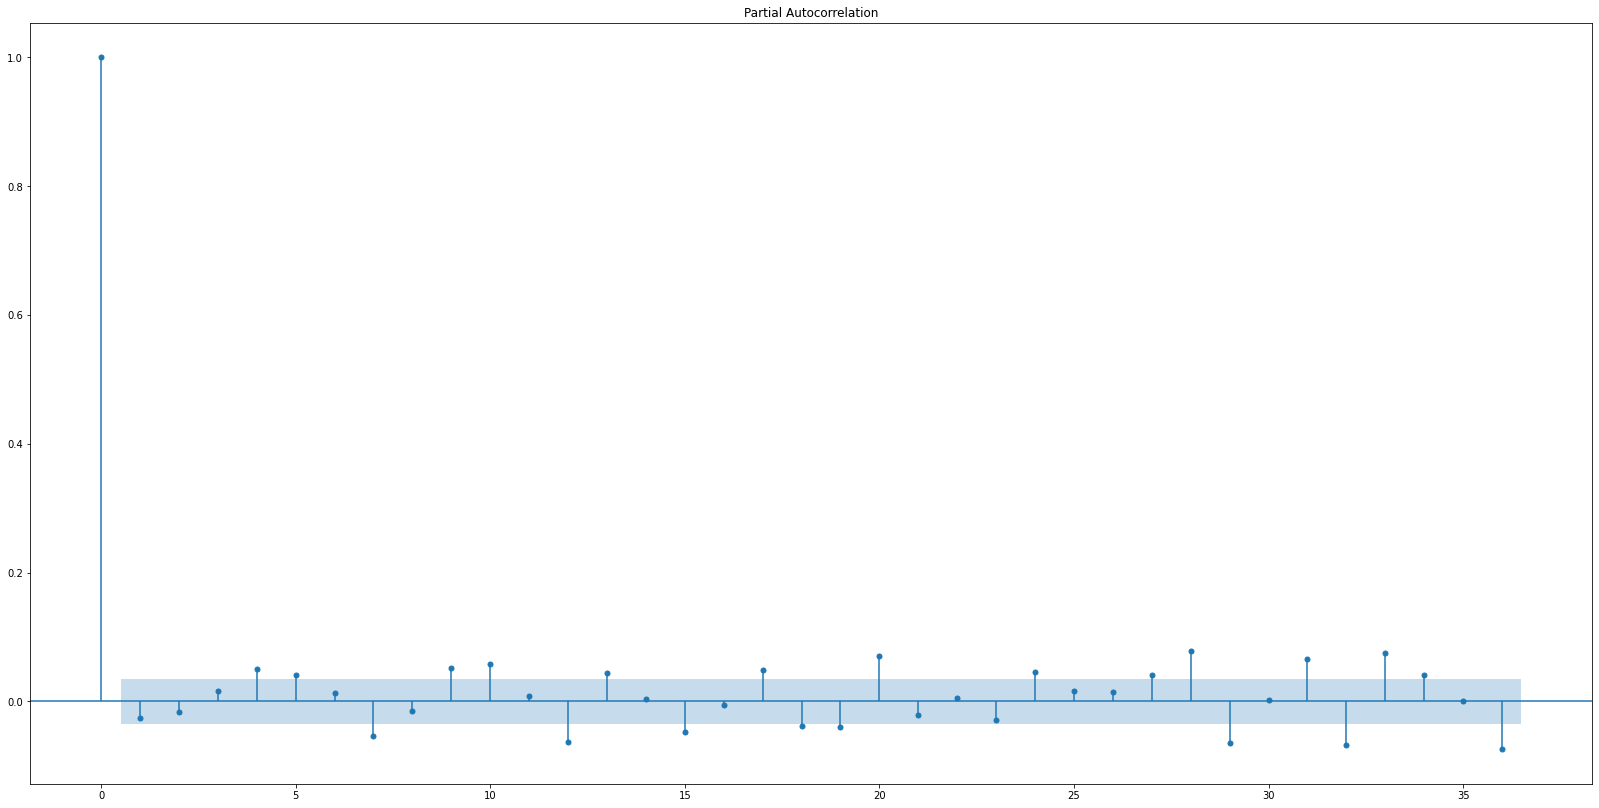

In [28]:
plot_pacf(df['diff'])
plt.show()

In [29]:
from pmdarima.arima import auto_arima
auto_arima_model = auto_arima(df_train['price'], start_p=0, start_q=0, max_p=15, max_q=15, max_d=3)

In [30]:
auto_arima_model


ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [32]:
# fit and ARIMA (3,1,4) model

model = ARIMA(df_train['price'], order=(2, 1, 3)).fit()


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 3165
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -24649.454
Date:                Fri, 28 Jan 2022   AIC                          49310.908
Time:                        15:14:34   BIC                          49347.266
Sample:                             0   HQIC                         49323.951
                               - 3165                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7987      0.016     51.279      0.000       0.768       0.829
ar.L2         -0.8871      0.014    -62.800      0.000      -0.915      -0.859
ma.L1         -0.8360      0.018    -45.367      0.0

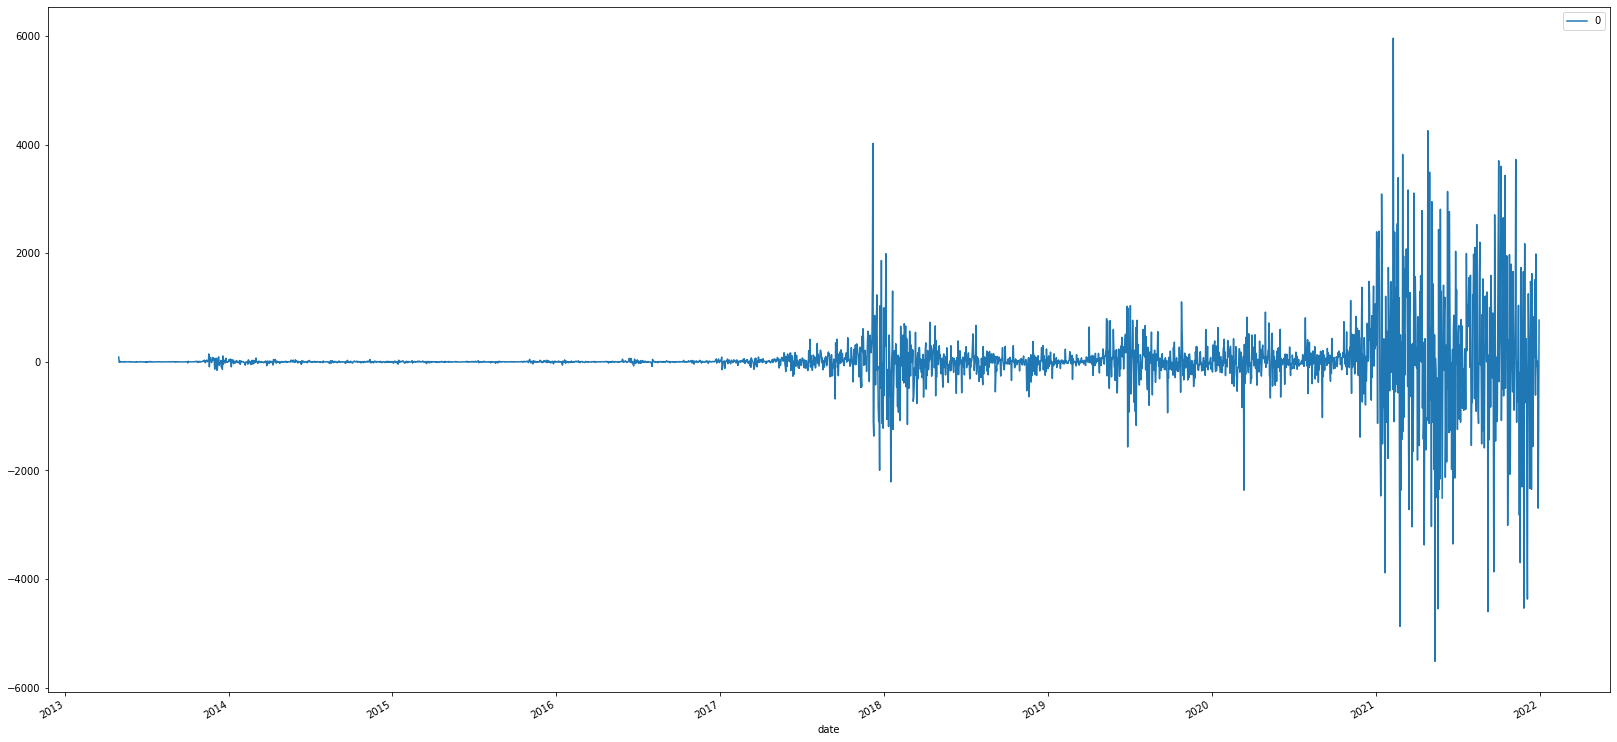

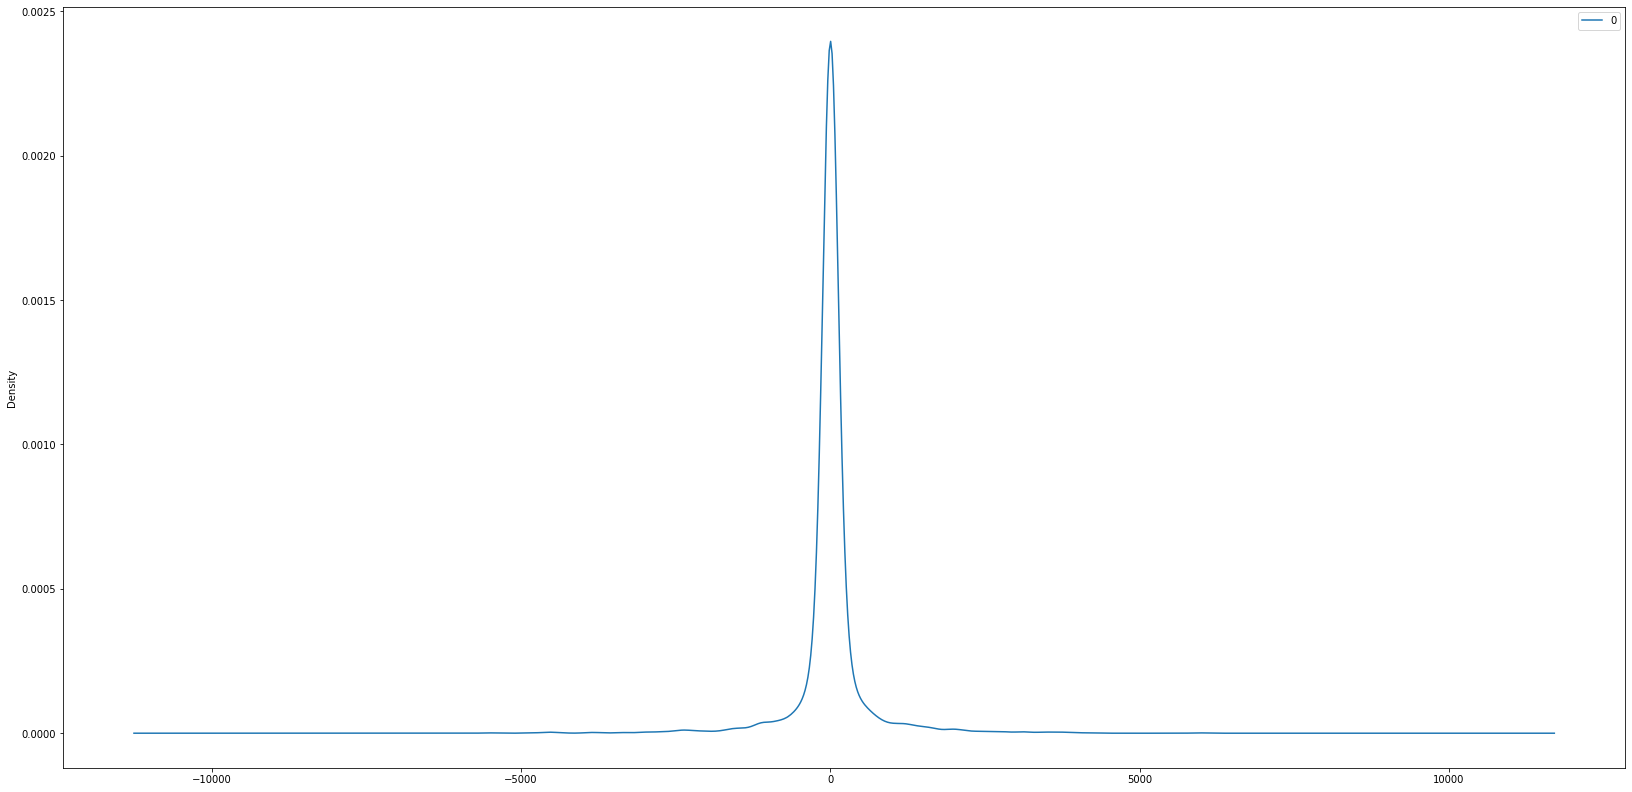

                 0
count  3165.000000
mean     13.402862
std     584.857210
min   -5515.831804
25%     -19.717741
50%       1.022773
75%      38.537024
max    5963.127954


In [33]:
# summary of fit model
print(model.summary())
# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())


In [34]:
print_adf(residuals)

 
              adf_stats: -9.208983428875358
              p: 1.9104210116940526e-15 
              used lag: 28 
              number of observations: 3136
            
              CI 99%: -3.4324369453939885
              CI 95%: -2.862462083609354
              CI 90%: -2.567260846851735
              information criterion (AIC): 48802.25486787153
            


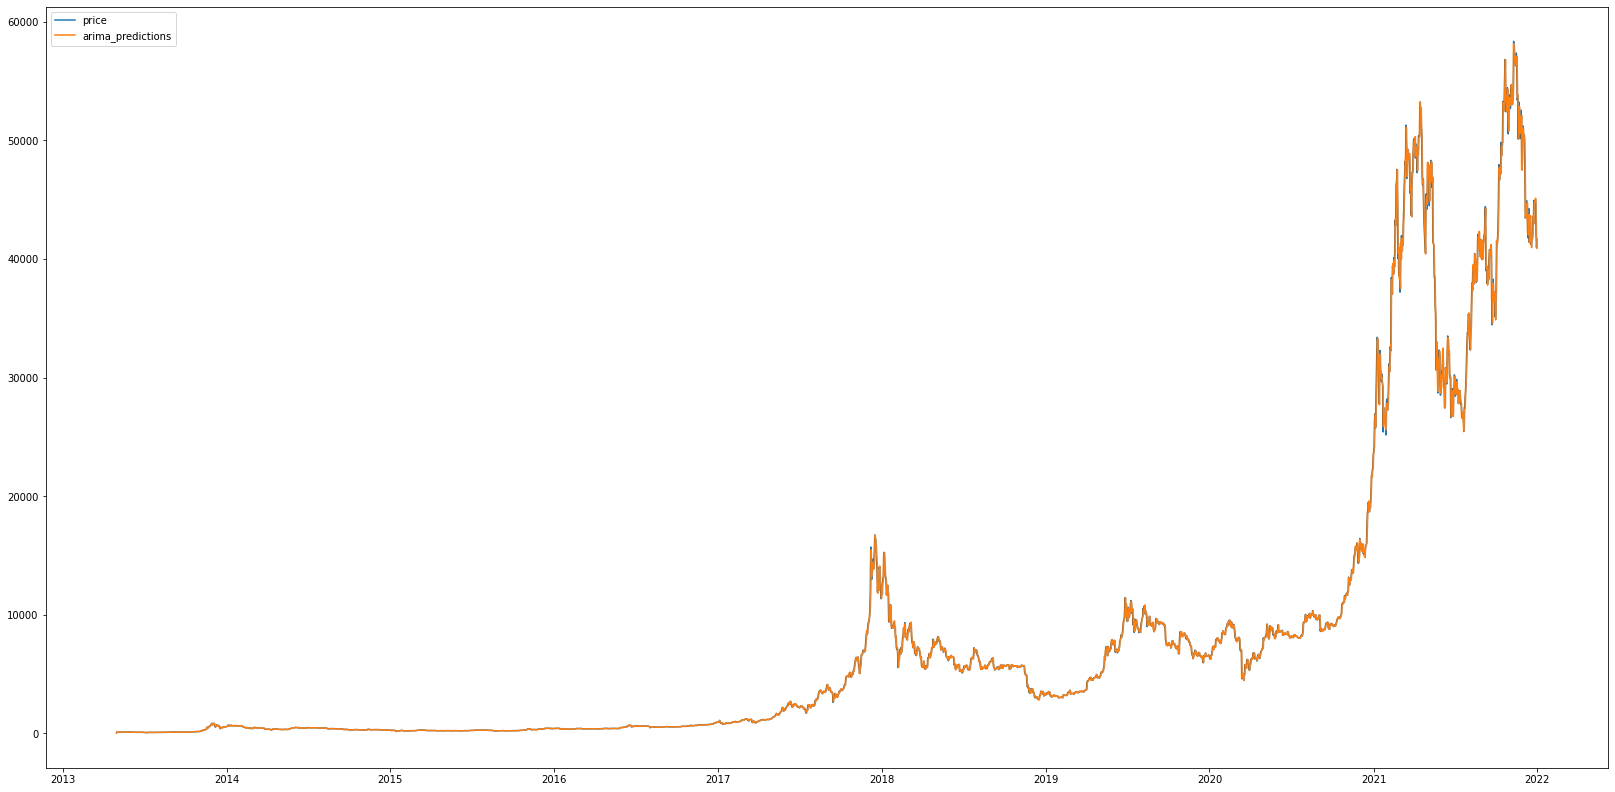

In [35]:
plt.plot(df_train['price'], label='price')
# this is called in-sample predictions, predictions on test data
plt.plot(model.predict(), label='arima_predictions')
plt.legend()
plt.show()


In [36]:
import numpy as np
rmse_no_seasonality = np.sqrt(mean_squared_error(df_train['price'], model.predict()))


In [37]:
rmse_no_seasonality

584.9183853147897

In [38]:
model.forecast()

3165    41598.362234
dtype: float64

In [39]:
df_test.head()

,price,diff
date,,
2022-01-01,40724.329876,-948.024779
2022-01-02,42039.991125,1315.661249
2022-01-03,41678.048233,-361.942892
2022-01-04,41182.386219,-495.662014
2022-01-05,40712.022755,-470.363464


In [40]:
model.predict(start=3166, end=3170)


3166    41574.790308
3167    41633.573416
3168    41701.430986
3169    41703.482375
3170    41644.927204
Name: predicted_mean, dtype: float64

In [43]:
# add predictions from both models

df_test['predictions'] = model.predict(start=3166, end=3194).values
df_test.head()


,price,diff,predictions
date,,,
2022-01-01,40724.329876,-948.024779,41574.790308
2022-01-02,42039.991125,1315.661249,41633.573416
2022-01-03,41678.048233,-361.942892,41701.430986
2022-01-04,41182.386219,-495.662014,41703.482375
2022-01-05,40712.022755,-470.363464,41644.927204


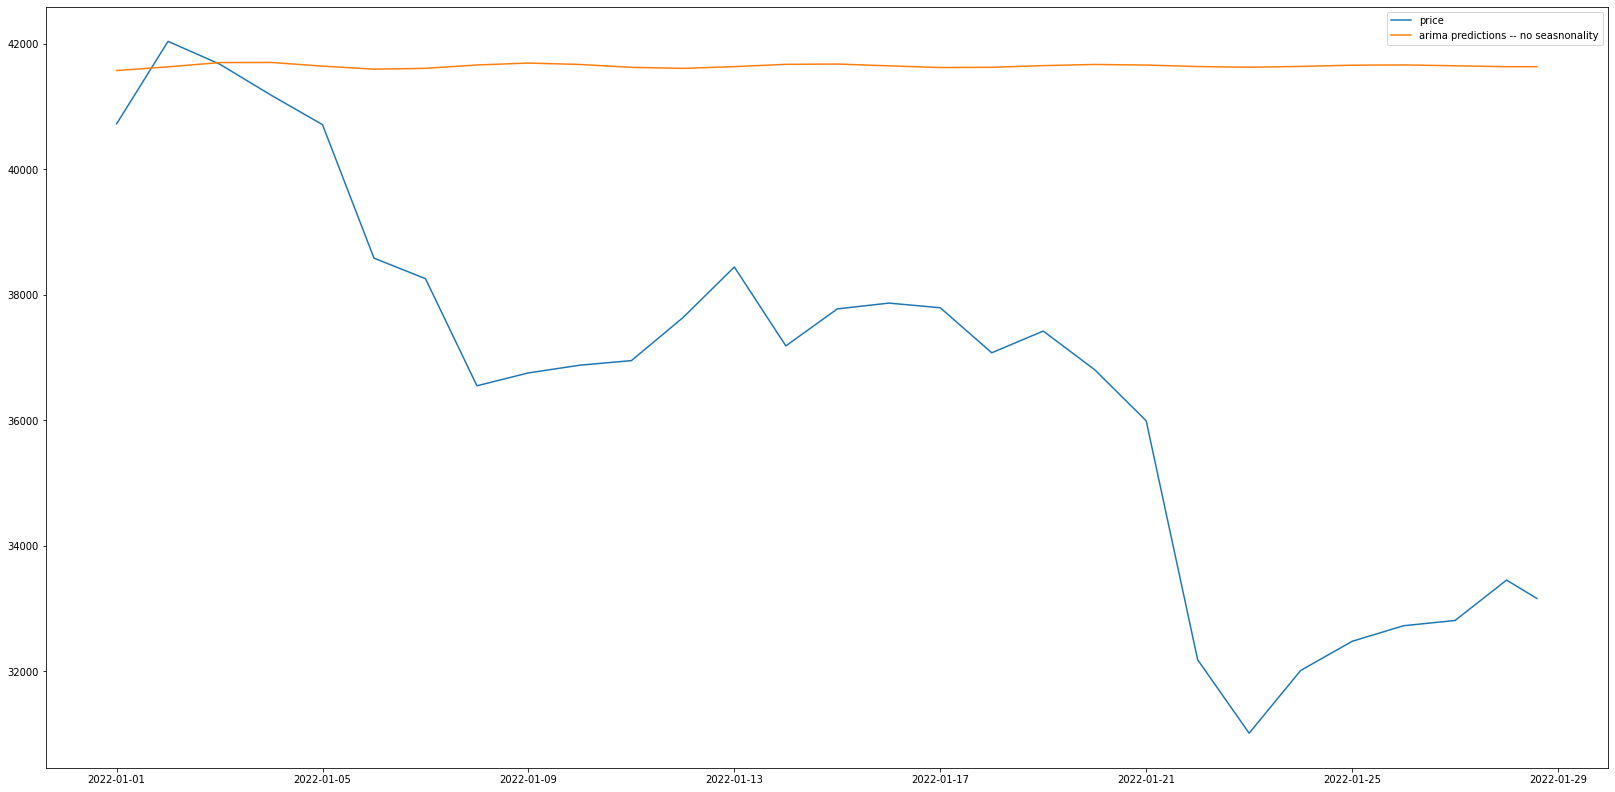

In [44]:
plt.plot(df_test['price'], label='price')
plt.plot(df_test['predictions'], label='arima predictions -- no seasnonality')
plt.legend()
plt.show()

In [45]:
df.head()

,price,diff
date,,
2013-05-01,88.6291,-17.6837
2013-05-02,80.5923,-8.0368
2013-05-03,75.1575,-5.4348
2013-05-04,86.2273,11.0698
2013-05-05,88.4403,2.2130


In [46]:
df.tail()

,price,diff
date,,
2022-01-25 00:00:00,32475.015385,464.852293
2022-01-26 00:00:00,32723.735164,248.719779
2022-01-27 00:00:00,32807.243920,83.508756
2022-01-28 00:00:00,33451.639390,644.395470
2022-01-28 14:10:26,33157.810831,-293.828559


In [50]:
df['timestep'] = list(range(len(df)))
df_train = df.loc['2013':'2021']
df_test = df.loc['2022']
df.head()


,price,diff,timestep
date,,,
2013-05-01,88.6291,-17.6837,0
2013-05-02,80.5923,-8.0368,1
2013-05-03,75.1575,-5.4348,2
2013-05-04,86.2273,11.0698,3
2013-05-05,88.4403,2.2130,4


In [51]:
df_train_func = df_train.set_index('timestep')
df_test_func = df_test.set_index('timestep')
df_test_func = df_test_func['price']

df_test_func.head()


timestep
3165    40724.329876
3166    42039.991125
3167    41678.048233
3168    41182.386219
3169    40712.022755
Name: price, dtype: float64

In [52]:
X = df_train_func['price'].values
y = df_test_func.values

print(X)

[   88.6291        80.5923        75.1575     ... 42181.44257441
 40960.33793102 41672.35465483]


In [53]:

print(y)

[40724.32987592 42039.99112525 41678.04823295 41182.38621861
 40712.02275452 38583.94745569 38256.89466271 36548.87513398
 36754.38120421 36877.34917712 36950.15061656 37634.1497167
 38443.01960598 37184.99854358 37774.60160623 37867.28048941
 37793.20421965 37075.1727624  37421.41158885 36804.8180586
 35990.19122236 32181.22920674 31010.32254524 32010.16309215
 32475.01538529 32723.7351641  32807.24391965 33451.63939007
 33157.81083144]


predicted=41598.362234, expected=40724.329876
predicted=40718.744347, expected=42039.991125
predicted=42089.037296, expected=41678.048233
predicted=41693.332980, expected=41182.386219
predicted=41072.703376, expected=40712.022755
predicted=40701.032921, expected=38583.947456
predicted=38852.508332, expected=38256.894663
predicted=38514.194033, expected=36548.875134
predicted=36583.434776, expected=36754.381204
predicted=36734.144466, expected=36877.349177
predicted=36798.697930, expected=36950.150617
predicted=36899.416895, expected=37634.149717
predicted=37643.880858, expected=38443.019606
predicted=38471.987622, expected=37184.998544
predicted=37250.365015, expected=37774.601606
predicted=37799.233257, expected=37867.280489
predicted=37803.977493, expected=37793.204220
predicted=37727.971787, expected=37075.172762
predicted=37100.125946, expected=37421.411589
predicted=37487.468972, expected=36804.818059
predicted=36852.337356, expected=35990.191222
predicted=36000.381446, expected=3

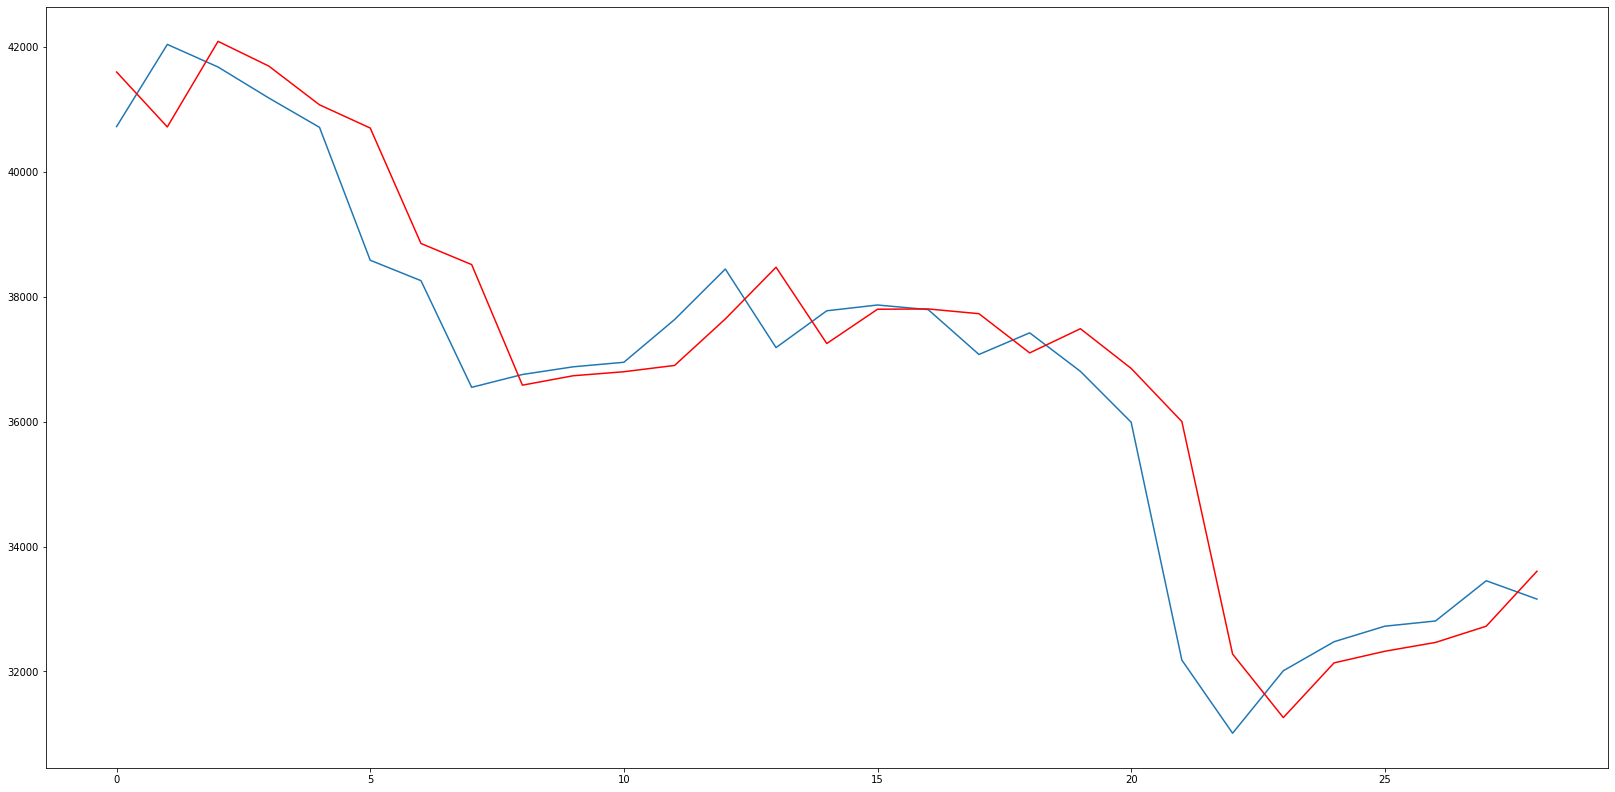

In [55]:

history = [x for x in X]
predictions = list()
# walk-forward validation
for t in range(len(y)):
	model = ARIMA(history, order=(2, 1, 3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = y[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()